# Pacing Strategy for Trail Running
Provide multiple GPX files from past runs. Based on 100m segments, an elevation related pace will be calculated (simple regression). This pace can then be applied on a new run also provided as GPX file.

## Helper Functions

In [2]:
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def distance(lat1, lon1, lat2, lon2):
    earthRadius = 6371000

    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  
    return earthRadius * c

def gain(elevation_delta):
    if elevation_delta > 0:
        return elevation_delta
    else:
        return 0

def time_delta(t1, t0):
    if t0 is pd.NaT:
        return int(0)
    else:
        return datetime.timedelta.total_seconds(t1-t0)

def distance_to_segment(value):
    if math.isnan(value):
        return int(0)
    else:
        return int(value/100)

## Load Baseline GPX Files
This file includes actual runs from which we calculate for 100m segments the elevation speed ratio. Assumption is that speed correlates strongly with elevation.

### Load File
Load the GPX file using the [GPXPY](https://github.com/tkrajina/gpxpy) library.

In [1]:
import gpxpy
import gpxpy.gpx

gpx_file = open('data/osterfeld.gpx', 'r')
gpx = gpxpy.parse(gpx_file)

### Convert File to Data Frame
Converts the GPX data in a data frame with a number of additional columns which are calculated to arrive at the desired mapping: 100m segment elevation delta vs. 100m average pace. The new columns provide the following data:
* Elevation Delta: The difference in elevation to the previous track point.
* Time Delta: The time difference to the previous track point (with Garmin in hires recording, this is always one second).
* Distance Delta: The distance to the previous track point (line of sight).
* Distance Sum: The accumulated distance of the track up tp this trackpoint.
* Distance Segment: The number of the 100m segment this trackpoint belongs to.

In [181]:
cols = [ 'lat', 'lon', 'elevation', 'time' ]
idx = []
rows = []

row = 0
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            idx.append(row)
            rows.append([point.latitude, point.longitude, point.elevation, point.time])
            row = row + 1
            
base = pd.DataFrame(data=rows, index=idx, columns=cols)

base['elevation_delta'] = base.elevation.diff().shift(0)

base['time_prev'] = base.time.shift(+1)
base['time_delta'] = base.apply(
    lambda row: time_delta(row['time'], row['time_prev']), axis=1)
del base['time']
del base['time_prev']


base['lat_prev'] = base.lat.shift(+1)
base['lon_prev'] = base.lon.shift(+1)
base['distance_delta'] = base.apply(
    lambda row: distance(row['lat'],row['lon'], row['lat_prev'],row['lon_prev']), axis=1)
del base['lat_prev']
del base['lon_prev']

base['distance_sum'] = base['distance_delta'].cumsum(axis = 0)
base['distance_segment'] = base.apply(
    lambda row: distance_to_segment(row['distance_sum']), axis=1)

base.tail(10)

,lat,lon,elevation,elevation_delta,time_delta,distance_delta,distance_sum,distance_segment
16125,47.482712,11.120129,745.599976,0.000000,1.0,2.706271,30112.553491,301
16126,47.482730,11.120156,745.599976,0.000000,1.0,2.824598,30115.378089,301
16127,47.482746,11.120186,745.599976,0.000000,1.0,2.904079,30118.282168,301
16128,47.482763,11.120215,745.599976,0.000000,1.0,2.859356,30121.141524,301
16129,47.482778,11.120243,745.599976,0.000000,1.0,2.669332,30123.810856,301
16130,47.482792,11.120267,745.599976,0.000000,1.0,2.380674,30126.191531,301
16131,47.482807,11.120286,745.400024,-0.199951,1.0,2.269532,30128.461063,301
16132,47.482819,11.120307,745.400024,0.000000,1.0,2.035678,30130.496741,301
16133,47.482826,11.120322,745.400024,0.000000,1.0,1.351719,30131.848460,301
16134,47.482831,11.120338,745.400024,0.000000,1.0,1.312184,30133.160644,301


### Group the Data Frame by Segment
Groups the data frame by segment and calculates for each segment the elevation change and pace.

In [182]:
base_g = base.groupby('distance_segment').agg(
    {
        'elevation_delta': ['sum'],
        'distance_delta': ['sum'], 
        'time_delta': ['sum']})
base_g['pace_segment'] = 16.7/(base_g[('distance_delta','sum')]/base_g[('time_delta','sum')])
base_g.head(10)

,elevation_delta,distance_delta,time_delta,pace_segment
,sum,sum,sum,
distance_segment,,,,
0,1.599976,98.979409,53.0,8.942264
1,0.200012,100.717302,48.0,7.958911
2,2.599976,97.756270,37.0,6.320822
3,0.000000,100.501443,33.0,5.483503
4,1.000000,101.449695,31.0,5.103022
5,1.200012,100.581485,33.0,5.479140
6,1.799988,99.389501,34.0,5.712877
7,3.000000,99.690327,33.0,5.528119


### Plot Elevation Delta vs. Pace For Each Segment

(0, 20)

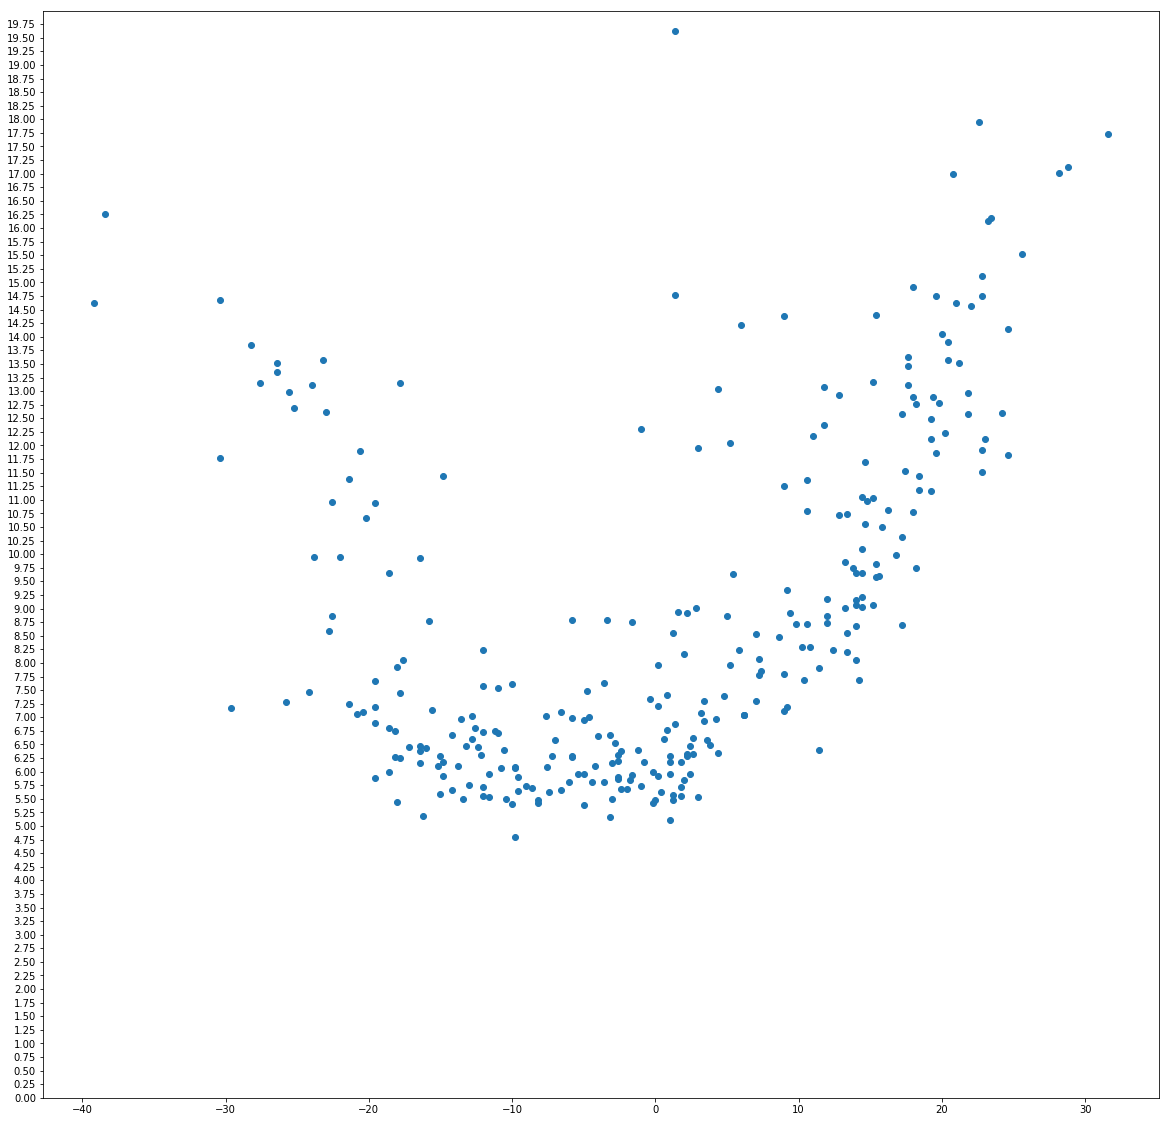

In [314]:
plt.figure(figsize=(20,20))
plt.yticks(np.arange(0, 20, 0.25))
plt.scatter(base_g[('elevation_delta','sum')], base_g['pace_segment'])
plt.ylim(0, 20)

### Create Prediction Model

#### Preparation of Data
Create arrays with all data, just uphill and just downhill data. Remove extreme values.

In [240]:
base_g_sorted = base_g.sort_values(by=('elevation_delta','sum'))
x_arr = base_g_sorted[('elevation_delta','sum')].values
y_arr = base_g_sorted['pace_segment'].values

x_all_arr = []
y_all_arr = []
x_up_arr = []
y_up_arr = []
x_down_arr = []
y_down_arr = []

for i in range(0, len(x_arr)):
    if y_arr[i] < 20:
        x_all_arr.append(x_arr[i])
        y_all_arr.append(y_arr[i])
        if x_arr[i] > 0:
            x_up_arr.append(x_arr[i])
            y_up_arr.append(y_arr[i])
        else:
            x_down_arr.append(x_arr[i])
            y_down_arr.append(y_arr[i])


#### Option 1: Parabolic Regression
We keep it simple and use square regression.

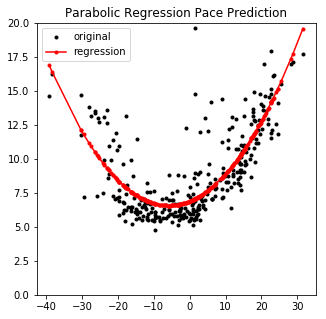

In [251]:
(a_para,b_para,c_para) = polyfit(x_all_arr, y_all_arr, 2)
yp_all_arr = polyval([a_para, b_para, c_para], x_all_arr)
plt.figure(figsize=(5,5))
plt.title('Parabolic Regression Pace Prediction')
plt.plot(x_all_arr, y_all_arr, 'k.')
plt.plot(x_all_arr, yp_all_arr, 'r.-')
plt.legend(['original','regression'])
plt.ylim(0, 20)
plt.show();

#### Linear Regression

Firstly, for uphill data:

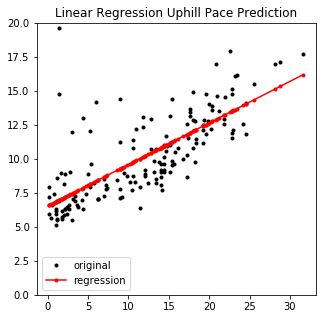

In [252]:
(a_lin_up,b_lin_up) = polyfit(x_up_arr, y_up_arr, 1)
yp_up_arr = polyval([a_lin_up, b_lin_up], x_up_arr)
plt.figure(figsize=(5,5))
plt.title('Linear Regression Uphill Pace Prediction')
plt.plot(x_up_arr, y_up_arr, 'k.')
plt.plot(x_up_arr, yp_up_arr, 'r.-')
plt.legend(['original','regression'])
plt.ylim(0, 20)
plt.show();

Now for downhill data:

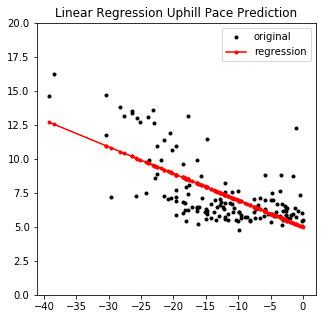

In [253]:
(a_lin_down,b_lin_down) = polyfit(x_down_arr, y_down_arr, 1)
yp_down_arr = polyval([a_lin_down, b_lin_down], x_down_arr)
plt.figure(figsize=(5,5))
plt.title('Linear Regression Uphill Pace Prediction')
plt.plot(x_down_arr, y_down_arr, 'k.')
plt.plot(x_down_arr, yp_down_arr, 'r.-')
plt.legend(['original','regression'])
plt.ylim(0, 20)
plt.show();

Downhill could also benefit from parabolic regression:

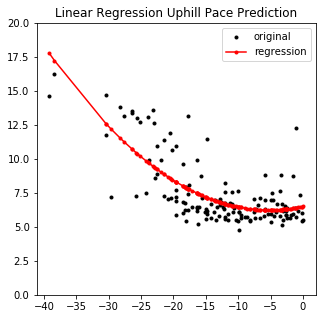

In [254]:
(a_para_down,b_para_down,c_para_down) = polyfit(x_down_arr, y_down_arr, 2)
yp_down_arr = polyval([a_para_down, b_para_down, c_para_down], x_down_arr)
plt.figure(figsize=(5,5))
plt.title('Linear Regression Uphill Pace Prediction')
plt.plot(x_down_arr, y_down_arr, 'k.')
plt.plot(x_down_arr, yp_down_arr, 'r.-')
plt.legend(['original','regression'])
plt.ylim(0, 20)
plt.show();

#### Prediction Formula Based on Above Models
Usage: `predict_pace(elevation, base_pace, model)` with model being one of the following strings:
* manual: The manually configured values will be used
* parabolic: The parabolic model will be used for uphill and downhill
* linear: The linear model will be used, one for uphill, another one for downhill
* mixed: The linear model will be used for uphill, the parabilic for downhill

In [330]:
uphill_penalty_per_m=6/20
downhill_penalty_per_m=3/20

def predict_pace_raw(elevation, base_pace, model):
    if model=='manual':
        if elevation > 0:
            return base_pace+elevation*uphill_penalty_per_m
        else:
            return base_pace+abs(elevation)*downhill_penalty_per_m

    elif model=='parabolic':
        return a_para*elevation**2+b_para*elevation+c_para
    
    elif model=='linear':
        if elevation >= 0:
            return a_lin_up*elevation+b_lin_up
        else:
            return a_lin_down*elevation+b_lin_down
    
    elif model=='mixed':
        if elevation > 0:
            return a_lin_up*elevation+b_lin_up
        else:
            return a_para_down*elevation**2+b_para_down*elevation+c_para_down
        
def predict_pace(elevation, base_pace, model, min_pace=19):
    pace = predict_pace_raw(elevation, base_pace, model)
    if pace > min_pace:
        return min_pace
    else:
        return pace

Small test:

In [331]:
elevation_test_arr = [-30, -20, -10, 0, 10, 20, 30]
models = ['manual', 'parabolic', 'linear', 'mixed']

def run_test(model):
    test_results = []
    for elevation in elevation_test_arr:
        test_results.append(predict_pace(elevation, 6.5, model))
    return test_results

all_results = []

for model in models:
    all_results.append(run_test(model))

results = pd.DataFrame(data=np.array(all_results).transpose(), index=elevation_test_arr, columns=models)
results

,manual,parabolic,linear,mixed
-30,11.0,11.976651,10.886123,12.373408
-20,9.5,8.423647,8.922500,8.419060
-10,8.0,6.726878,6.958877,6.461914
0,6.5,6.886344,6.532836,6.501971
10,9.5,8.902045,9.590237,9.590237
20,12.5,12.773982,12.647638,12.647638
30,15.5,18.502154,15.705039,15.705039


## Load Target GPX File
This file includes a track (no run), the track is split in 100m segments and based on the elevation, the speed is forecast.

### Load File
Load the GPX file using the [GPXPY](https://github.com/tkrajina/gpxpy) library.

In [3]:
target_gpx_file = open('data/supertrail.gpx', 'r')
target_gpx = gpxpy.parse(target_gpx_file)

### Convert File to Data Frame
Converts the GPX data in a data frame with a number of additional columns which are calculated to arrive at the desired mapping: 100m segment elevation delta vs. 100m average pace. The new columns provide the following data:
* Elevation Delta: The difference in elevation to the previous track point.
* Distance Delta: The distance to the previous track point (line of sight).
* Distance Sum: The accumulated distance of the track up tp this trackpoint.
* Distance Segment: The number of the 100m segment this trackpoint belongs to.

In [185]:
import pandas as pd

cols = [ 'lat', 'lon', 'elevation' ]
idx = []
rows = []

row = 0
for track in target_gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            idx.append(row)
            rows.append([point.latitude, point.longitude, point.elevation])
            row = row + 1

target = pd.DataFrame(data=rows, index=idx, columns=cols)

target['elevation_delta'] = target.elevation.diff().shift(0)

target['lat_prev'] = target.lat.shift(+1)
target['lon_prev'] = target.lon.shift(+1)
target['distance_delta'] = target.apply(
    lambda row: distance(row['lat'],row['lon'], row['lat_prev'],row['lon_prev']), axis=1)
del target['lat_prev']
del target['lon_prev']

target['distance_sum'] = target['distance_delta'].cumsum(axis = 0)
target['distance_segment'] = target.apply(
    lambda row: distance_to_segment(row['distance_sum']), axis=1)

target.tail(10)      

,lat,lon,elevation,elevation_delta,distance_delta,distance_sum,distance_segment
4076,47.471816,11.028861,750.834778,0.000000,10.263241,63237.662461,632
4077,47.471854,11.028811,750.834778,0.000000,5.654871,63243.317333,632
4078,47.471996,11.028593,749.509277,-1.325500,22.755113,63266.072446,632
4079,47.472168,11.028406,749.509277,0.000000,23.734739,63289.807185,632
4080,47.472220,11.028372,749.509277,0.000000,6.321686,63296.128871,632
4081,47.472291,11.028326,747.859070,-1.650208,8.618726,63304.747597,633
4082,47.472242,11.028155,747.859070,0.000000,13.959875,63318.707472,633
4083,47.472172,11.027828,747.680237,-0.178833,25.781026,63344.488499,633
4084,47.472175,11.027372,749.413391,1.733154,34.275500,63378.763999,633
4085,47.472177,11.026993,749.413391,0.000000,28.487269,63407.251267,634


### Group the Data Frame by Segment
Groups the data frame by segment and calculates for each segment the elevation change and target pace.

In [317]:
target_g = target.groupby('distance_segment').agg(
    {
        'elevation': ['mean'],
        'elevation_delta': ['sum'],
        'distance_delta': ['sum']})

target_g.tail(10)

,elevation,elevation_delta,distance_delta
,mean,sum,sum
distance_segment,,,
625,758.319206,1.177734,105.999900
626,755.855172,-4.078796,92.943208
627,754.707361,0.500732,78.014867
628,755.162150,0.556335,125.165215
629,756.784035,1.922913,100.225374
630,753.347107,-7.599731,82.496878
631,751.046712,1.398376,114.237952
632,750.304337,-1.779785,104.186730


### Predict The Pace With Elevation Penalties and Caluculate Overall Time
Applies base pace on each segment and adds penalties for up or downhill elevation.

In [334]:
target_g['pace_segment'] = target_g.apply(
    lambda row: predict_pace(row[('elevation_delta','sum')], 6.5, 'parabolic'), axis=1)

target_g['time_delta'] = target_g[('distance_delta','sum')]/(16.7/target_g['pace_segment'])
target_g['time_sum'] = target_g['time_delta'].cumsum(axis = 0)/3600

target_g.tail(8)

,elevation,elevation_delta,distance_delta,pace_segment,time_delta,time_sum
,mean,sum,sum,,,
distance_segment,,,,,,
627,754.707361,0.500732,78.014867,6.943130,32.435171,9.428886
628,755.162150,0.556335,125.165215,6.949723,52.087636,9.443355
629,756.784035,1.922913,100.225374,7.129795,42.789601,9.455241
630,753.347107,-7.599731,82.496878,6.595852,32.583067,9.464291
631,751.046712,1.398376,114.237952,7.056578,48.271199,9.477700
632,750.304337,-1.779785,104.186730,6.722177,41.937821,9.489349
633,748.202942,-0.095886,82.635128,6.876001,34.023904,9.498801
634,749.413391,0.000000,28.487269,6.886344,11.746894,9.502064


### Plot Results

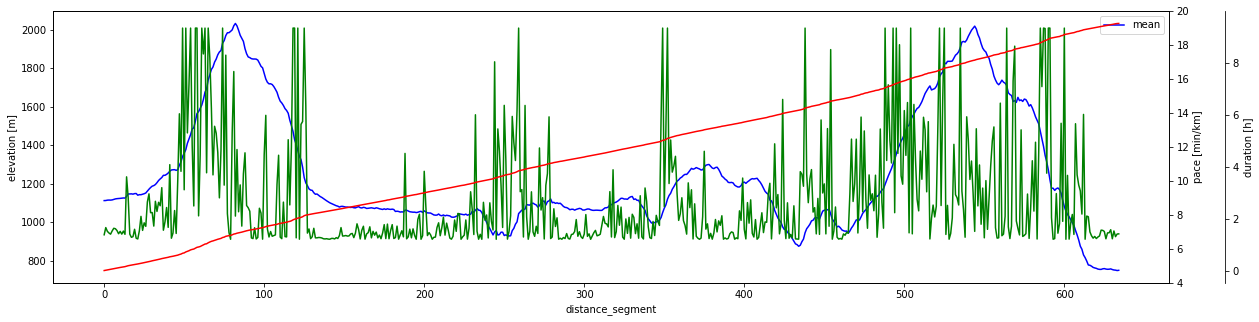

In [327]:
fig,ax = plt.subplots()

ax.set_ylabel('elevation [m]')
ax.set_xlabel('segments [100m]')

ax2 = ax.twinx()
ax2.set_ylim(4, 20)
ax2.set_ylabel('pace [min/km]')
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
ax3.set_ylabel('duration [h]')


target_g['elevation'].plot(ax=ax, style='b-', figsize=(20,5))
target_g['pace_segment'].plot(ax=ax2, style='g-')
target_g['time_sum'].plot(ax=ax3, style='r-')